# Planning Stage: Individual Assignment 1 - Data Description and Exploratory Data Analysis

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(infer)
library(cowplot)
library(broom)
library(GGally)
library(modelr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.2.1     ✔ tune         1.2.1
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.1.0
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
door_dash <- read_csv("https://raw.githubusercontent.com/recompton/STAT301_A1/refs/heads/main/data/cleaned_full_data.csv")

New names:
• `` -> `...1`
Rows: 3290 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): restaurant, url, city, price_range, category_1, category_2
dbl (4): ...1, distance, star, num_reviews

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Data Description:

The data set for my group is a compilation of eight data sets that each show restaurants within under 30 minutes delivery time in eight different populous cities in Canada. The original data was collected from the Door Dash website and the eight data sets were compiled and cleaned by Kaggle user Satoshi_S: https://www.kaggle.com/code/satoshiss/clean-restaurant-raw-data. 



In [3]:
paste("There are", nrow(door_dash), "observations and", ncol(door_dash), "variables in this dataset.")

[1] "There are 3290 observations and 10 variables in this dataset."

The 10 variables are ...1 (an index), restaurant (the name of the restaurant), url (the Door Dash website link for this restaurant), distance (in miles or minutes depending on how the data was entered), star (star rating out of 5), num_reviews (the number of reviews for that restaurant), city (the city the restaurant is located in), and price_range (4 ranks indicated by number of $).

In [4]:
summary(door_dash)

      ...1         restaurant            url               distance     
 Min.   :   0.0   Length:3290        Length:3290        Min.   : 0.010  
 1st Qu.: 822.2   Class :character   Class :character   1st Qu.: 0.500  
 Median :1644.5   Mode  :character   Mode  :character   Median : 1.000  
 Mean   :1644.5                                         Mean   : 5.039  
 3rd Qu.:2466.8                                         3rd Qu.: 1.600  
 Max.   :3289.0                                         Max.   :30.000  
                                                                        
      star        num_reviews          city           price_range       
 Min.   :1.000   Min.   :   10.0   Length:3290        Length:3290       
 1st Qu.:4.300   1st Qu.:   57.0   Class :character   Class :character  
 Median :4.500   Median :  182.0   Mode  :character   Mode  :character  
 Mean   :4.451   Mean   :  570.4                                        
 3rd Qu.:4.700   3rd Qu.:  560.0                   

### Pre-selection of variables:

I will be dropping the first variable labeled ...1. This variable is an index and therefore should not be involved in any model I create. Additionally, I will also be dropping the url variable. Each of the urls are identical except for the unique numerical sequence that indicates which website to direct to, essentially making the URL equivalent to an ID and therefore irrelavent to my future analysis.

### Question: 

a) I want to examine the association between the city a restaurant is in (response) and predictors related to type of restaurant such as price and category, as well as the predictors related to the performance of a restaurant such as number of reviews and star rating. Ultimately, I am asking the following: What is the association between the city (response variable) and the characteristics of restaurants located there (predictors)?

b) My question is focused on inference because I am taking information from an observational study and looking to glean information into associations not causations. 

In [5]:
door_dash <- door_dash %>%
    select(distance, star, num_reviews, city, price_range, category_1, category_2)
head(door_dash)

distance,star,num_reviews,city,price_range,category_1,category_2
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
0.90,4.0,640,Branpton,$$,Indian,Wraps
2.00,4.0,301,Branpton,$$,Chinese,Chicken
1.00,4.2,890,Branpton,$$,Bakery,Chicken
0.40,4.4,109,Branpton,$,Italian,Sandwiches
0.09,4.5,481,Branpton,$$,Fast Food,Sandwiches
0.90,3.7,730,Branpton,$$,Shawarma,Vegetarian


Warning message:
“Removed 280 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


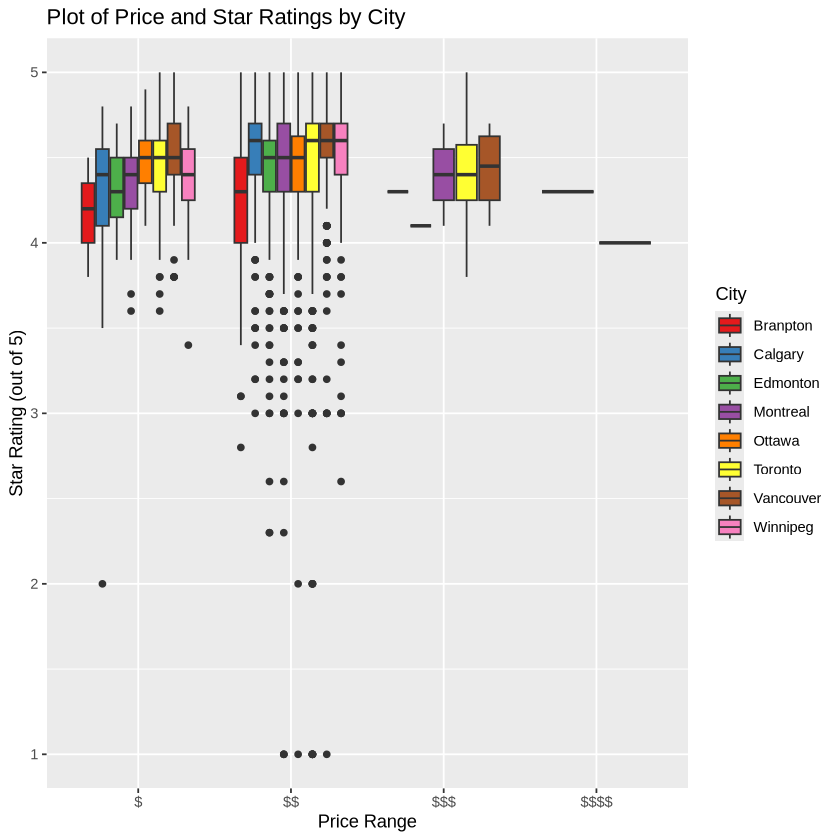

In [6]:
door_dash_plot <- door_dash %>%
    ggplot(aes(x = price_range, y = star, fill = city)) +
    geom_boxplot() + 
    labs(title="Plot of Price and Star Ratings by City", x="Price Range", y = "Star Rating (out of 5)", fill = "City") +
    scale_fill_brewer(palette="Set1")
door_dash_plot

This plot shows that the distribution of the relationship between star rating and price range differs by city. Some cities do not have have some of the higher price ranges, but all of the cities have the lower prices. This plot suggests that there are trends that can be used to find an association between features and the target of the city.

# Planning Stage: Individual Assignment 2 - Methods and Plan & Computational Code and Output

I will be changing my question to the following: What is the association between star rating (response) and characteristics of a restaurant for restaurants within 30 minute delivery times of their cities' respecitive downtowns?

I will still be dropping the URL, ...1, and restaurant variables. 

### Data Wrangling:

In [52]:
door_dash_adapted <- door_dash %>%
    filter(distance < 10) %>%
    mutate(price_range = recode(price_range, "$$$" = "$$$+", "$$$$" = "$$$+"))
arrange(door_dash_adapted, desc(distance)) %>% head()

distance,star,num_reviews,city,price_range,category_1,category_2
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
3.3,4.7,27,Calgary,$,Grocery,Snacks
2.6,4.4,1000,Branpton,$$,Belgian,Waffles
2.6,4.3,NA,Branpton,$$,Jamaican,Seafood
2.6,4.7,155,Montreal,$$,Poutineries,Snacks
2.5,3.8,25,Branpton,$$,Fries,Italian
2.5,4.6,305,Montreal,$$,Cafe,Breakfast


I noticed that the distance variable varied widely in values with many values being less than 1 and some being as large as 30. This was worrisome because the variable was supposed to be the distance (in miles) from the restaurant to the delivery location and the distance should be bounded by deliveries that could be made in 30 minutes. After investigating the original city data sets, I discovered that the data had been converted incorrectly and in some cases the distance was measured in minutes and in the others in miles. To fix this for my model, I filtered the distance variable to only have the values below 10 and so now the maximum distance is 3.3, a perfectly reasonable amount of miles to travel in the timeframe. Additionally, due to the very small amount of values at the highest level in the price_range variable, I combined the third and fourth tiers into one \$\$\$+ tier.

### Methods and Plan

I will be fitting an additive multiple linear regression model to investigate the association between star rating and the covariates. This model is appropriate because my response variable is numerical. Additionally, I will not be predicting using my model since this is an observational study and I am looking into association between the response and the covariates. This model assumes that the residuals are normally distributed and that there is minimal multicollinearity. An additive model also assumes that the effect of changes in a predictor on the response is independent of the effects of changes in other predictors. Linear regression is, however, limited by the assumption that the relationship is in fact linear.

### Computational Code and Output

In [53]:
door_dash_model <- lm(star ~ ., data = door_dash_adapted)
door_dash_model_results <- tidy(door_dash_model, conf.int = TRUE) %>% 
    mutate_if(is.numeric, round, 2)
door_dash_model_results

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),4.01,0.25,16.18,0.00,3.53,4.50
distance,0.02,0.01,1.32,0.19,-0.01,0.04
num_reviews,0.00,0.00,2.07,0.04,0.00,0.00
cityCalgary,0.20,0.03,6.18,0.00,0.14,0.26
cityEdmonton,0.16,0.03,4.60,0.00,0.09,0.22
cityMontreal,0.11,0.04,2.92,0.00,0.04,0.19
cityOttawa,0.11,0.05,2.01,0.04,0.00,0.21
cityToronto,0.19,0.03,6.44,0.00,0.13,0.25
cityVancouver,0.24,0.03,7.77,0.00,0.18,0.30


Warning message:
“Removed 611 rows containing non-finite outside the scale range
(`stat_smooth()`).”
Warning message:
“Removed 611 rows containing missing values or values outside the scale range
(`geom_point()`).”


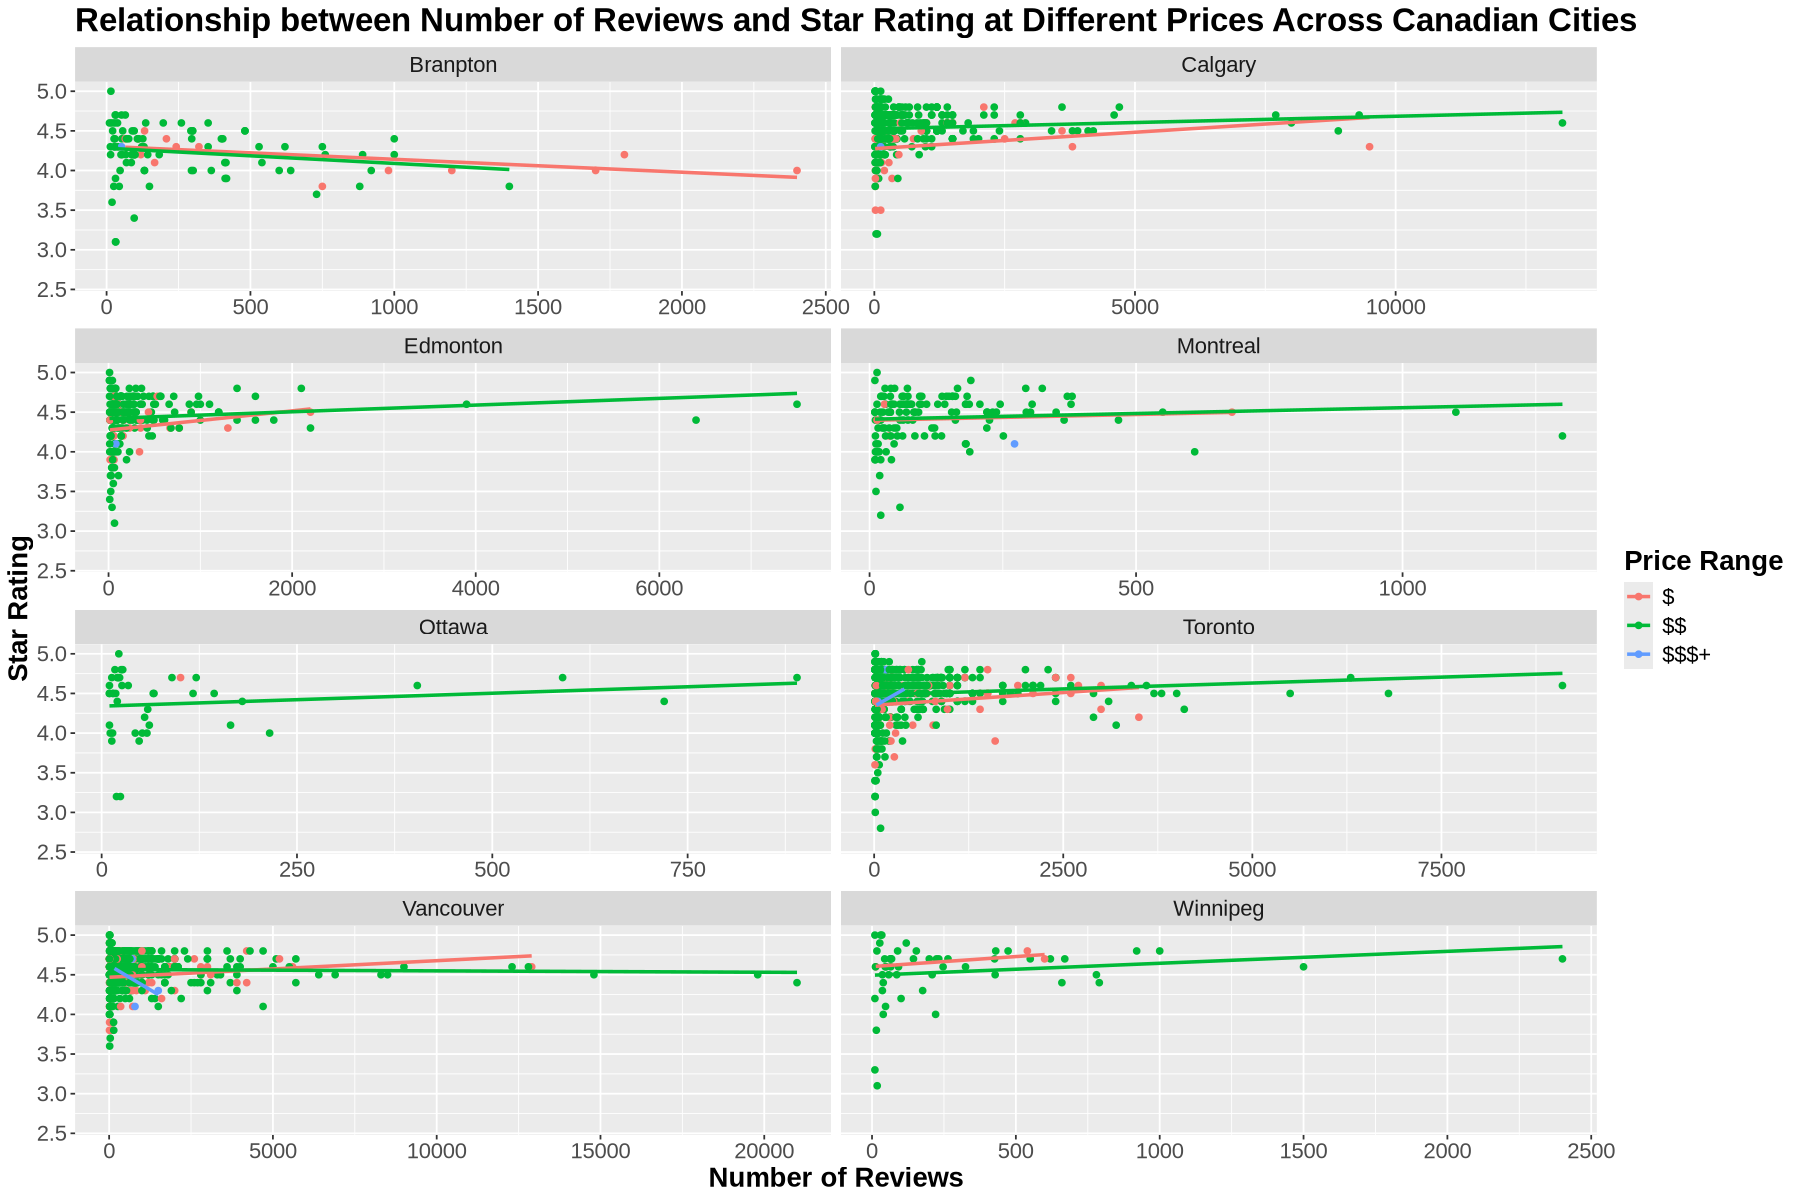

In [55]:
options(repr.plot.width = 15, repr.plot.height = 10)

MLR_door_dash_adapted_add_plot <- 
     door_dash_adapted %>%
     ggplot(aes(x = num_reviews, y = star, color = price_range)) +
     geom_point() +
     geom_smooth(method = "lm", se = FALSE, aes(group = price_range), formula = y ~ x) +  
    facet_wrap(~ city, ncol = 2, scales = "free_x") +
   labs(title = "Relationship between Number of Reviews and Star Rating at Different Prices Across Canadian Cities",
        x = "Number of Reviews",
        y = "Star Rating",
        color = "Price Range"
   ) +
    ylim(2.6, 5) +
   theme(
     text = element_text(size = 16.5),
     plot.title = element_text(face = "bold"),
     axis.title = element_text(face = "bold"),
     legend.title = element_text(face = "bold"),
    plot.margin = margin(5, 5, 5, 5)
   )

MLR_door_dash_adapted_add_plot

The city and number of reviews as well as price range covariates have significant p.values at 0.05 significance level. This indicates that we can reject the null hypothesis that these covariates are not significantly related to the star rating of a restaurant. The category_1 and category_2 variables had higher p.values over all but even so there were a few individual categories like Wagyu and Wine that were significantly related to the star rating. Together, these results suggest a strong association between the number of reviews, the price, and the star rating of the restaurant, but they do not suggest a strong association between the category of the restaurant and the star rating.